In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "GRAS"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
r = min(5000/len(dataset_), 1)
_, dataset = train_test_split(dataset_, test_size=r, stratify=dataset_['class'], random_state=42)
#dataset = dataset_
dataset.head()

,id,sequence,length,class
18360,Manes.11G161300.1.p,MVLSESDNIAHGSNGNKSNSSHPPQLQDQDSMKETSSLSSPLAAAG...,315,0
17585,DCAR_027105,MKVDEETRGEAYKRSNERLRRKNFADSCSVLQSIVPNLLPKATKER...,171,0
796,Brast05G284000.2.p,MASTPQPPRGDLAAPPPAAAAQDLAALGLAAARSLRHRPPRHGGQM...,780,1
13114,KHN47390.1,MEEAQGSSSSLPPFLTKIYEMVDDPSTNSIVSWSATNRSFIVWNPP...,391,0
4521,GSMUA_Achr8P09400_001,MARKRLVSELDLQPDSSYNPGRLPRRAATGASSTSSGNPTCSGDFS...,672,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
2787,0.004255,0.000000,0.000000,0.006383,0.002128,0.002128,0.000000,0.004255,0.000000,0.002128,...,0.000000,0.010638,0.002128,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
1402,0.037199,0.002188,0.006565,0.010941,0.002188,0.008753,0.000000,0.002188,0.002188,0.017505,...,0.002188,0.002188,0.000000,0.000000,0.004376,0.002188,0.000000,0.0,0.0,0.002188
3289,0.006289,0.001258,0.001258,0.005031,0.002516,0.001258,0.001258,0.000000,0.002516,0.011321,...,0.001258,0.000000,0.000000,0.001258,0.001258,0.000000,0.001258,0.0,0.0,0.000000
2242,0.013913,0.003478,0.005217,0.006957,0.001739,0.001739,0.001739,0.001739,0.001739,0.005217,...,0.000000,0.000000,0.005217,0.001739,0.001739,0.000000,0.000000,0.0,0.0,0.000000
2996,0.047970,0.000000,0.005535,0.007380,0.005535,0.003690,0.001845,0.003690,0.001845,0.011070,...,0.000000,0.000000,0.000000,0.000000,0.001845,0.001845,0.000000,0.0,0.0,0.001845


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 441)
X_test: (1000, 441)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 603ms/step - accuracy: 0.4531 - loss: 0.6931

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5916 - loss: 0.6883   

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6555 - loss: 0.6674 - val_accuracy: 0.9362 - val_loss: 0.2714


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9062 - loss: 0.3610

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9591 - loss: 0.2008 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9594 - loss: 0.1806 - val_accuracy: 0.9812 - val_loss: 0.0630


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0272

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9737 - loss: 0.0778 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9734 - loss: 0.0794 - val_accuracy: 0.9850 - val_loss: 0.0527


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9531 - loss: 0.1433

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9806 - loss: 0.0672

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9817 - loss: 0.0630 - val_accuracy: 0.9725 - val_loss: 0.0729


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0268

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9887 - loss: 0.0346 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9876 - loss: 0.0371 - val_accuracy: 0.9712 - val_loss: 0.0749


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0379

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0287 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0318 - val_accuracy: 0.9825 - val_loss: 0.0646


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0210

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9826 - loss: 0.0426 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9832 - loss: 0.0429 - val_accuracy: 0.9837 - val_loss: 0.0535


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0864

30/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9893 - loss: 0.0339

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9901 - loss: 0.0300 - val_accuracy: 0.9825 - val_loss: 0.0658


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0021

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0138 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9959 - loss: 0.0157 - val_accuracy: 0.9837 - val_loss: 0.0669


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0044

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9941 - loss: 0.0155 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9943 - loss: 0.0153 - val_accuracy: 0.9837 - val_loss: 0.0664


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0068 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9973 - loss: 0.0080 - val_accuracy: 0.9862 - val_loss: 0.0668


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 8.4934e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9886 - loss: 0.0341     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9883 - loss: 0.0326 - val_accuracy: 0.9837 - val_loss: 0.0712


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9844 - loss: 0.0314

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0130

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9953 - loss: 0.0136 - val_accuracy: 0.9837 - val_loss: 0.0730


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0037

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0053 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9812 - val_loss: 0.0879


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0056 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9983 - loss: 0.0066 - val_accuracy: 0.9837 - val_loss: 0.0778


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.2402e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9991 - loss: 0.0027     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0033 - val_accuracy: 0.9787 - val_loss: 0.0994


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 9.3402e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9967 - loss: 0.0064     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0066 - val_accuracy: 0.9825 - val_loss: 0.0848


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 3.5816e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0021     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9862 - val_loss: 0.0928


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 4.3000e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9998 - loss: 0.0024     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9812 - val_loss: 0.0970


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9844 - loss: 0.0170

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9949 - loss: 0.0089 

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9963 - loss: 0.0074 - val_accuracy: 0.9812 - val_loss: 0.1056


Epoch 21/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 7.6307e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9999 - loss: 0.0020     

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9997 - loss: 0.0019 - val_accuracy: 0.9825 - val_loss: 0.0918



[Train Accuracy: 99.94% - Test Accuracy: 98.40%]


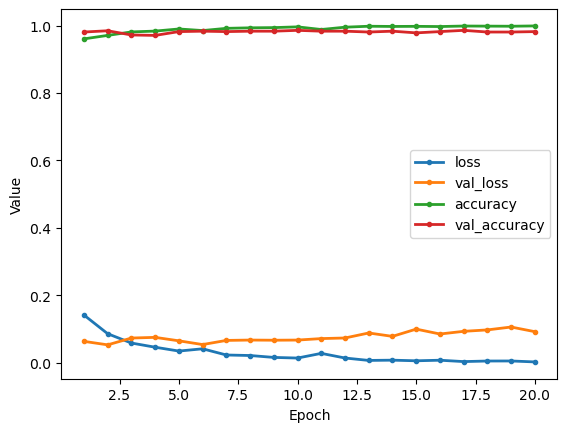

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
2787,0.000000,0.0,0.000000,0.002132,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
1402,0.019737,0.0,0.000000,0.006579,0.000000,0.000000,0.000000,0.0,0.000000,0.002193,...,0.0,0.0,0.0,0.0,0.002193,0.000000,0.0,0.0,0.0,0.0
3289,0.000000,0.0,0.001259,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.001259,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2242,0.001742,0.0,0.001742,0.005226,0.000000,0.000000,0.001742,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2996,0.027726,0.0,0.000000,0.000000,0.001848,0.001848,0.000000,0.0,0.001848,0.003697,...,0.0,0.0,0.0,0.0,0.000000,0.001848,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (4000, 8825)
X_test: (1000, 8825)
y_train: (4000,)
y_test: (1000,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,259,456 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,302,721 (8.78 MB)

 Trainable params: 2,302,721 (8.78 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 29s 611ms/step - accuracy: 0.4844 - loss: 0.6932

 7/50 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4853 - loss: 0.6931   

14/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5049 - loss: 0.6929

21/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5300 - loss: 0.6923

29/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5487 - loss: 0.6910

37/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5680 - loss: 0.6888

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5908 - loss: 0.6846

50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6077 - loss: 0.6794 - val_accuracy: 0.9775 - val_loss: 0.3671


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.3631

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9707 - loss: 0.3251 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9761 - loss: 0.2819

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9786 - loss: 0.2471

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9801 - loss: 0.2207

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9812 - loss: 0.2000

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9823 - loss: 0.1833

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9826 - loss: 0.1779 - val_accuracy: 0.9937 - val_loss: 0.0167


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0044

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0043 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0059

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0063

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9987 - loss: 0.0062

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9988 - loss: 0.0061

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0059

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0058 - val_accuracy: 0.9937 - val_loss: 0.0172


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0037

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0029 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0025

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0024

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0023

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0023 - val_accuracy: 0.9962 - val_loss: 0.0095


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.4235e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7210e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3426e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.1570e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.0622e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9885e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9279e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.9130e-04 - val_accuracy: 0.9962 - val_loss: 0.0116


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 2.0359e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010     

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7065e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.9747e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.4958e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1861e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.9302e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 6.8674e-04 - val_accuracy: 0.9962 - val_loss: 0.0086


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 5.3266e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.6614e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.4832e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2978e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0679e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9298e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7812e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.7348e-04 - val_accuracy: 0.9962 - val_loss: 0.0100


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.9897e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.3829e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9975e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7480e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.6532e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5802e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5079e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.4907e-04 - val_accuracy: 0.9962 - val_loss: 0.0090


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 1.2577e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8164e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8871e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.4043e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.1580e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9525e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7996e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 2.7666e-04 - val_accuracy: 0.9962 - val_loss: 0.0093


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.0799e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.7641e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0020e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1120e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1597e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2938e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3689e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3906e-04 - val_accuracy: 0.9987 - val_loss: 0.0069


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 7.5869e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2580e-04 

16/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3572e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4055e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3799e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3727e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3674e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3648e-04 - val_accuracy: 0.9975 - val_loss: 0.0089


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 3.8782e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.0487e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.8253e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6893e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5705e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4690e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3856e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.3667e-04 - val_accuracy: 0.9975 - val_loss: 0.0105


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 9.1244e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2130e-04 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4833e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5979e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6051e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5849e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5523e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5443e-04 - val_accuracy: 0.9975 - val_loss: 0.0110


Epoch 14/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 6.1670e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.1560e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 6.0337e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.1624e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5496e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5838e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 7.5572e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 7.5381e-05 - val_accuracy: 0.9962 - val_loss: 0.0144


Epoch 15/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 4.4636e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.7829e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0637e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0283e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.0216e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2260e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.4266e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 5.4595e-05 - val_accuracy: 0.9975 - val_loss: 0.0090


Epoch 16/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 3.8697e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8093e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8525e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8860e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9457e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9643e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.0138e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.0257e-05 - val_accuracy: 0.9962 - val_loss: 0.0121


Epoch 17/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 5.5116e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9858e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7047e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8420e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8523e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8932e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9867e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.9992e-05 - val_accuracy: 0.9962 - val_loss: 0.0139


Epoch 18/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9016e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.6569e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 5.2227e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.8114e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.5508e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3697e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2027e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.1503e-05 - val_accuracy: 0.9975 - val_loss: 0.0111


Epoch 19/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.6295e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.3402e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.2203e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.5155e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.7652e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9254e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 2.9992e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.0108e-05 - val_accuracy: 0.9962 - val_loss: 0.0138


Epoch 20/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.9153e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7903e-05 

17/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.9816e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8586e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7381e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.7352e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8192e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 3.8329e-05 - val_accuracy: 0.9975 - val_loss: 0.0097



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


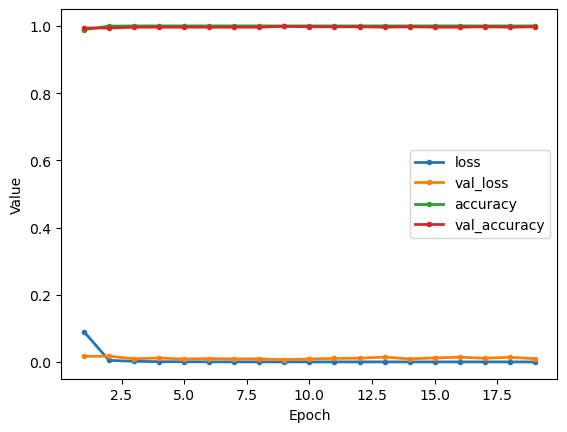

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYV,YYYW,YYYX,YYYY
2787,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1402,0.008791,0.0,0.0,0.002198,0.000000,0.0,0.0,0.0,0.000000,0.002198,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3289,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2242,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2996,0.016667,0.0,0.0,0.000000,0.001852,0.0,0.0,0.0,0.001852,0.001852,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      37,302,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 37,343,489 (142.45 MB)

 Trainable params: 37,343,489 (142.45 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 41s 844ms/step - accuracy: 0.5312 - loss: 0.6931

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 126ms/step - accuracy: 0.5078 - loss: 0.6932 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5017 - loss: 0.6931

 4/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5013 - loss: 0.6931

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5029 - loss: 0.6931

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5072 - loss: 0.6931

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5087 - loss: 0.6931

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5106 - loss: 0.6931

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 0.5134 - loss: 0.6930

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5149 - loss: 0.6930

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.5177 - loss: 0.6930

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5215 - loss: 0.6929

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5262 - loss: 0.6929

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.5311 - loss: 0.6928

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5364 - loss: 0.6928

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5417 - loss: 0.6927

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5464 - loss: 0.6926

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5508 - loss: 0.6926

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.5550 - loss: 0.6925

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5592 - loss: 0.6924

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 0.5635 - loss: 0.6923

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 0.5679 - loss: 0.6922

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5724 - loss: 0.6921

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 0.5770 - loss: 0.6920

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5816 - loss: 0.6918

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.5862 - loss: 0.6917

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.5908 - loss: 0.6915

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5954 - loss: 0.6913

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.5999 - loss: 0.6912

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6044 - loss: 0.6910

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.6088 - loss: 0.6907

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6131 - loss: 0.6905

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6173 - loss: 0.6903

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.6215 - loss: 0.6900

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.6256 - loss: 0.6897

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6296 - loss: 0.6894

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 0.6335 - loss: 0.6890

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6374 - loss: 0.6887

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6412 - loss: 0.6883

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6449 - loss: 0.6879

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6486 - loss: 0.6874

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 0.6522 - loss: 0.6870

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6557 - loss: 0.6865

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6592 - loss: 0.6859

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6626 - loss: 0.6853

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6659 - loss: 0.6847

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6691 - loss: 0.6841

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6723 - loss: 0.6834

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6754 - loss: 0.6826

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6785 - loss: 0.6818

50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 185ms/step - accuracy: 0.6814 - loss: 0.6811 - val_accuracy: 0.9750 - val_loss: 0.4380


Epoch 2/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.9844 - loss: 0.4213

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9883 - loss: 0.4145 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 142ms/step - accuracy: 0.9887 - loss: 0.4108

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9886 - loss: 0.4058

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 0.9890 - loss: 0.4004

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 0.9895 - loss: 0.3949

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 0.9898 - loss: 0.3898

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 0.9901 - loss: 0.3844

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9902 - loss: 0.3791

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9902 - loss: 0.3740

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9904 - loss: 0.3688

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9903 - loss: 0.3639

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9901 - loss: 0.3591

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.9900 - loss: 0.3542

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9900 - loss: 0.3496

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9899 - loss: 0.3450

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9899 - loss: 0.3404

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9900 - loss: 0.3359

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9900 - loss: 0.3314

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 0.9901 - loss: 0.3270

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.9901 - loss: 0.3227

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9902 - loss: 0.3184

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9903 - loss: 0.3141

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9904 - loss: 0.3100

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 0.9904 - loss: 0.3059

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9905 - loss: 0.3019

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 0.9906 - loss: 0.2980

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9906 - loss: 0.2942

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9907 - loss: 0.2904

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9908 - loss: 0.2868

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9909 - loss: 0.2832

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9910 - loss: 0.2797

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9911 - loss: 0.2763

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9911 - loss: 0.2730

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9912 - loss: 0.2697

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9913 - loss: 0.2666

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 0.9913 - loss: 0.2635

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9914 - loss: 0.2605

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9915 - loss: 0.2575

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9915 - loss: 0.2547

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9916 - loss: 0.2519

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9916 - loss: 0.2491

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9917 - loss: 0.2465

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9917 - loss: 0.2439

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9918 - loss: 0.2413

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9918 - loss: 0.2389

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9919 - loss: 0.2364

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9920 - loss: 0.2341

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9920 - loss: 0.2317

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9921 - loss: 0.2295

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 0.9921 - loss: 0.2273 - val_accuracy: 0.9925 - val_loss: 0.0269


Epoch 3/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 224ms/step - accuracy: 1.0000 - loss: 0.0047

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 0.0043 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 0.0042

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 0.0041

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.0041

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0042

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0042

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0042

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0042

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0042

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0042

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0041

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0041

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0041

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 0.0041

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 0.0041

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0040

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0040

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0040

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 142ms/step - accuracy: 1.0000 - loss: 0.0040

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 0.0040

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 0.0039

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0039

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 0.0039

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0039

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0039

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0038

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 0.0038

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0038

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0038

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0038

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0037

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0037

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0037

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 0.0037

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 0.0037

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 0.0036

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0036

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0036

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0036

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0036

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 0.0036

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 0.0035

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0035

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0035

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0035

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0035

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0035

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0035

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0034

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 0.0034 - val_accuracy: 0.9975 - val_loss: 0.0172


Epoch 4/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - accuracy: 1.0000 - loss: 9.9125e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 0.0010    

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 0.0010

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 0.0010

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 146ms/step - accuracy: 1.0000 - loss: 9.9752e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 9.8263e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 9.7254e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 6s 145ms/step - accuracy: 1.0000 - loss: 9.7420e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.7290e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.6922e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.6816e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 9.6717e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 9.6566e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 9.6444e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.6548e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.6568e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.6725e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 9.6811e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 9.7004e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 9.7116e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 9.7231e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 9.7392e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 9.7758e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 9.8123e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - accuracy: 1.0000 - loss: 9.8376e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 1.0000 - loss: 9.8602e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.8765e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 1.0000 - loss: 9.9014e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 9.9220e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 142ms/step - accuracy: 1.0000 - loss: 9.9378e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 9.9565e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 9.9698e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 9.9807e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step - accuracy: 1.0000 - loss: 9.9951e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 0.0010    

36/50 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 1.0000 - loss: 0.0010

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0010

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0010

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0010

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0010

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 143ms/step - accuracy: 1.0000 - loss: 0.0010

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - accuracy: 1.0000 - loss: 0.0010

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0010

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 1.0000 - loss: 0.0010

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 0.0010

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 9.9971e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 9.9901e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 9.9884e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 9.9854e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 1.0000 - loss: 9.9811e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 149ms/step - accuracy: 1.0000 - loss: 9.9769e-04 - val_accuracy: 0.9950 - val_loss: 0.0178


Epoch 5/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 183ms/step - accuracy: 1.0000 - loss: 5.6344e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 5.4849e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 144ms/step - accuracy: 1.0000 - loss: 6.5232e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 141ms/step - accuracy: 1.0000 - loss: 7.3748e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 7.7212e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 7.9563e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 8.1842e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 8.3202e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 8.3530e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 8.3651e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 8.3610e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 8.3432e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - accuracy: 1.0000 - loss: 8.3333e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 8.3202e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 8.3034e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 8.2802e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 141ms/step - accuracy: 1.0000 - loss: 8.2644e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 8.2373e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 8.2007e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 8.1572e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 8.1141e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step - accuracy: 1.0000 - loss: 8.0669e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 8.0386e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 8.0109e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.9848e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.9601e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.9325e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 7.9003e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.8661e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.8319e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.7968e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.7621e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 7.7284e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.6965e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.6675e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.6391e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.6104e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.5802e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.5505e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.5196e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.4883e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 7.4581e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.4272e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3966e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3659e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3373e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.3091e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2810e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2535e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 7.2294e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 151ms/step - accuracy: 1.0000 - loss: 7.2062e-04 - val_accuracy: 0.9962 - val_loss: 0.0170


Epoch 6/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 9s 195ms/step - accuracy: 1.0000 - loss: 3.9563e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.5686e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.4813e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.2951e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 4.8257e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.2030e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 6s 140ms/step - accuracy: 1.0000 - loss: 5.4324e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.5741e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.6613e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.7089e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 1.0000 - loss: 5.7559e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.7711e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - accuracy: 1.0000 - loss: 5.7630e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - accuracy: 1.0000 - loss: 5.7463e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 5.7148e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 140ms/step - accuracy: 1.0000 - loss: 5.6784e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.6625e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.6422e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 1.0000 - loss: 5.6185e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.5906e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 5.5649e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.5355e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.5055e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.4748e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.4430e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 1.0000 - loss: 5.4124e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.3869e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 1.0000 - loss: 5.3680e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.3462e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 1.0000 - loss: 5.3237e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.3010e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.2775e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.2545e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.2310e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 1.0000 - loss: 5.2065e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.1828e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - accuracy: 1.0000 - loss: 5.1589e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.1347e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.1109e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0867e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0633e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - accuracy: 1.0000 - loss: 5.0403e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 5.0169e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.9936e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.9702e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.9466e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.9233e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.9002e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.8783e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 1.0000 - loss: 4.8565e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 1.0000 - loss: 4.8355e-04 - val_accuracy: 0.9975 - val_loss: 0.0158


Epoch 7/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step - accuracy: 1.0000 - loss: 3.3232e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 2.9574e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 2.7084e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 2.6139e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 2.5083e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 2.4408e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.3989e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.3568e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.3286e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 2.3280e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.3277e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 2.3313e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 2.3584e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 2.3897e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.4401e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.4802e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5158e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5450e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 2.5663e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 2.5835e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.5965e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6076e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6173e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 2.6250e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.6316e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.6366e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 135ms/step - accuracy: 1.0000 - loss: 2.6410e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 2.6435e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6443e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6435e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6415e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6405e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6388e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6365e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 2.6346e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6330e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6307e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6294e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6285e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6273e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6251e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 2.6229e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6210e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6188e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6160e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6135e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6103e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6067e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.6027e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 2.5985e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 2.5945e-04 - val_accuracy: 0.9975 - val_loss: 0.0158


Epoch 8/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 1.0000 - loss: 8.1016e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 129ms/step - accuracy: 1.0000 - loss: 8.5759e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 8.6482e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 9.4711e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.0350e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.1857e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.2853e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3641e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4225e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.4571e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.4901e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.5407e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.5753e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6005e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6204e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6375e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6603e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6786e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.6926e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 1.7095e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.7240e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.7343e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.7418e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.7484e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.7544e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 1.7587e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 1.7665e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.7733e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.7782e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.7884e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.7974e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.8050e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.8114e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.8168e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 1.8219e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8287e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8358e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8421e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8472e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8515e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8561e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.8603e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8643e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8679e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8714e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8749e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8777e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8800e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8819e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.8832e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 156ms/step - accuracy: 1.0000 - loss: 1.8846e-04 - val_accuracy: 0.9975 - val_loss: 0.0138


Epoch 9/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 10s 210ms/step - accuracy: 1.0000 - loss: 1.9834e-04

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.7492e-04 

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.5886e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.5004e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - accuracy: 1.0000 - loss: 1.5034e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4866e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.4588e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.4376e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.4123e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.3870e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.3699e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.3594e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 1.3575e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 1.3535e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.3483e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.3467e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.3450e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 1.3422e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3385e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 1.3369e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3348e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3326e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3322e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 1.3312e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3298e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3289e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 1.3281e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3266e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3250e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3236e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3223e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3203e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 1.3184e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.3167e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 1.3148e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3127e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3105e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3086e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3064e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3045e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - accuracy: 1.0000 - loss: 1.3025e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 1.3007e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2987e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2965e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2943e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2926e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2911e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2896e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2880e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 1.2863e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 1.0000 - loss: 1.2847e-04 - val_accuracy: 0.9975 - val_loss: 0.0163


Epoch 10/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 154ms/step - accuracy: 1.0000 - loss: 7.3518e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.2440e-04

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 1.3413e-04

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 1.3658e-04

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3473e-04

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.3701e-04

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.3764e-04

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3767e-04

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3676e-04

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3528e-04

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3361e-04

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 1.3179e-04

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2983e-04

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2930e-04

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2925e-04

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2924e-04

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.2950e-04

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.2946e-04

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.2922e-04

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2886e-04

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2832e-04

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2773e-04

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2707e-04

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2670e-04

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2636e-04

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2592e-04

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.2550e-04

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2515e-04

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2502e-04

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 1.2484e-04

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.2461e-04

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.2432e-04

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 1.2396e-04

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.2373e-04

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 1.2346e-04

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.2315e-04

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.2286e-04

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.2257e-04

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.2225e-04

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 1.2192e-04

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2169e-04

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 1.2148e-04

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2128e-04

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2115e-04

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.2104e-04

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2092e-04

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2077e-04

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 1.2063e-04

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2046e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 1.2027e-04

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 1.2008e-04 - val_accuracy: 0.9975 - val_loss: 0.0160


Epoch 11/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 1.0000 - loss: 3.3658e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 3.2918e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 3.4549e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 3.7998e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.1830e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.3806e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.5255e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 4.5955e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.7058e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.8131e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 4.8985e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.9809e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.0323e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.0887e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 5.1326e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.1840e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.2247e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.2534e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 5.2826e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 5.3100e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.3334e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.3568e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.3807e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.4120e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.4572e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.4992e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.5372e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.5787e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.6192e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.6527e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 5.6854e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.7138e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.7387e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.7606e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7793e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.7939e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.8130e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - accuracy: 1.0000 - loss: 5.8294e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8436e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8555e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8747e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8915e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9066e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9219e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9373e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9507e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9646e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 5.9767e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 6.0105e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 1.0000 - loss: 6.0423e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 1.0000 - loss: 6.0729e-05 - val_accuracy: 0.9975 - val_loss: 0.0148


Epoch 12/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 157ms/step - accuracy: 1.0000 - loss: 9.8489e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - accuracy: 1.0000 - loss: 8.2039e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 131ms/step - accuracy: 1.0000 - loss: 7.5061e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 6.9051e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.7844e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.6142e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.4154e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 6.2877e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 6.1838e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 6.0822e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 5.9869e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 5.9653e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.0019e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 6.0167e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.0266e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 6.0302e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.0490e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 6.0585e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 6.0653e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0615e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0549e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0421e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0368e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0259e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0189e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0101e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0079e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0089e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0142e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0171e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0162e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0133e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0079e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0035e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 5.9970e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9889e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9800e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.9716e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 5.9852e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0146e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0407e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0662e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.0881e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1088e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1269e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1434e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1575e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1703e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1823e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1937e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.2046e-05 - val_accuracy: 0.9975 - val_loss: 0.0138


Epoch 13/100


 1/50 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 1.0000 - loss: 3.4843e-05

 2/50 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 4.9970e-05

 3/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.3768e-05

 4/50 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 5.4624e-05

 5/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.5002e-05

 6/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.4902e-05

 7/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.4390e-05

 8/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.3897e-05

 9/50 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.3358e-05

10/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.2873e-05

11/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.2304e-05

12/50 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.3587e-05

13/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.4638e-05

14/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.5395e-05

15/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.6000e-05

16/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.6461e-05

17/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.6995e-05

18/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.7377e-05

19/50 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 5.7621e-05

20/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 5.7744e-05

21/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.7848e-05

22/50 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.8403e-05

23/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 5.8853e-05

24/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 5.9303e-05

25/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 5.9649e-05

26/50 ━━━━━━━━━━━━━━━━━━━━ 3s 134ms/step - accuracy: 1.0000 - loss: 5.9925e-05

27/50 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 6.0150e-05

28/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0308e-05

29/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0426e-05

30/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0500e-05

31/50 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 6.0638e-05

32/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0760e-05

33/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.0862e-05

34/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.1069e-05

35/50 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 1.0000 - loss: 6.1262e-05

36/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.1422e-05

37/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.1536e-05

38/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.1673e-05

39/50 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.1773e-05

40/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.1891e-05

41/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.1986e-05

42/50 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.2058e-05

43/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2109e-05

44/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2139e-05

45/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2156e-05

46/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2153e-05

47/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2139e-05

48/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2112e-05

49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.2069e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.2020e-05

50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 6.1974e-05 - val_accuracy: 0.9950 - val_loss: 0.0192



[Train Accuracy: 100.00% - Test Accuracy: 99.80%]


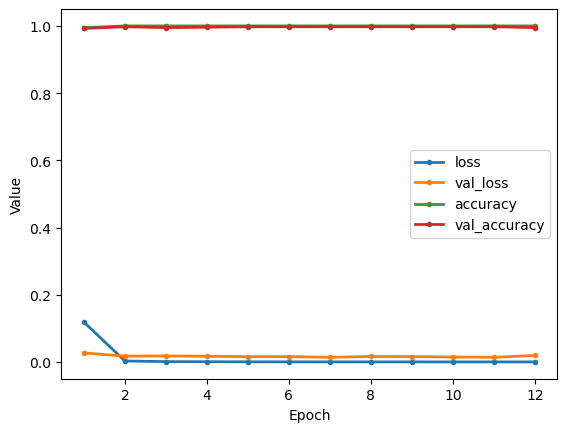

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/32 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step

 6/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

16/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

21/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

26/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

 5/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

10/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

15/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/GRAS/report_06CZHDGF.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################